In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'
from scipy.stats import pearsonr

from utils.shift import *
from utils.age import *
from utils.vis import (plot_performance_scatter, 
                       plot_repr_uncertainty, 
                       METHYLCLOCK_NAMES_MAPPER,
                       plot_covariate_panel)

%load_ext autoreload
%autoreload 2

#human clocks
clocks = pickle.load(open('subdata/clock_coefs.pkl', 'rb'))

# GSE90124 -> GSE54848 (Aging Skin -> Full reprogramming)

In [2]:
#Aging, Roos, 2017
dfa, meta = pd.read_pickle('datasets/GSE90124.pkl').values()
dfa = dfa.loc[meta.index]
print('Age, N sites', len(dfa.columns))

#Reprogramming (in vitro, Ohnuki)
dfr, metr = pd.read_pickle('datasets/GSE54848.pkl').values()
dfr = dfr.loc[metr.index]
print('Rep, N sites', len(dfr.columns))

#methylclock output
methclock = pd.read_csv('subdata/GSE54848_methylclock_results.csv', index_col=1).drop('Unnamed: 0', axis=1)
methclock['age'] = metr['DayReprog']
columns_include = ['Horvath', 'Levine', 'EN', 'skinHorvath', 'PedBE', 'Wu', 'TL', 'BLUP', 'Hannum', 'age']
methclock = methclock[columns_include]
groupr = methclock.groupby('age').mean()
groupr.columns = groupr.columns.map(METHYLCLOCK_NAMES_MAPPER)

#Days of reprogramming for pairwise comparison
repday0, repday1 = (0, 15)

Age, N sites 450531
Rep, N sites 485577


## Methylclock models predict different rejuvenation dynamics

In [3]:
# train other models
# different models same data

model_mapper = {'KNeighborsRegressor': 'kNN regressor',
                'HistGradientBoostingRegressor': 'HGB regressor',
                'SVR':'Support Vector regressor',
                'BayesianRidge': 'Bayesian ridge regressor',
                'RandomForestRegressor': 'Random forest regressor'
                }


cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

#import models
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

params = {
            KNeighborsRegressor: {"metric":['euclidean', 'l1', 'cosine'], 
                                  "n_neighbors":np.arange(2, 11),
                                  "weights":['uniform']},
            RandomForestRegressor: {"n_estimators":[200], 
                                    "max_depth":[3, 6, 10],
                                    'min_samples_split': [2, 5, 10],
                                    "n_jobs":[-1],},
            SVR: {"kernel":["linear"], "C":np.logspace(-1, 1, 10)},
            BayesianRidge: {},
            HistGradientBoostingRegressor: {"verbose":[0]},
          }

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=15)

perf_metrics = pd.DataFrame()
groupr2 = pd.DataFrame(index=yr)
for m, p in params.items():
    model = GridSearchCV(m(), p, scoring='neg_mean_absolute_error', refit=True, cv=cv_splitter)
    model.fit(X_train, y_train)
    print(model.best_estimator_)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    r_tr, p_tr = pearsonr(y_train, y_train_predict)
    r_te, p_te = pearsonr(y_test, y_test_predict)
    print(f'r train = {r_tr}')
    print(f'r test = {r_te}')
    print(f'r pval train = {p_tr}')
    print(f'r pval test = {p_te}')
    print(f'R2 train = {r2_score(y_train, y_train_predict)}')
    print(f'R2 test = {r2_score(y_test, y_test_predict)}')
    print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
    print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
    print('-'*30)

    y_rep_predict = model.predict(Xr_clock)
    groupr2[model_mapper[m.__name__]] = y_rep_predict

groupr2 = groupr2.groupby(groupr2.index).mean()

389 common sites
KNeighborsRegressor(metric='cosine', n_neighbors=4)
r train = 0.8439678217761898
r test = 0.6538186206104057
r pval train = 1.3547320209443015e-66
r pval test = 3.6487964606774405e-11
R2 train = 0.6987990725749825
R2 test = 0.4017683232033965
MAE train = 3.915124481327801
MAE test = 6.036543209876545
------------------------------
RandomForestRegressor(max_depth=6, min_samples_split=5, n_estimators=200,
                      n_jobs=-1)
r train = 0.9725728832575847
r test = 0.8288875567983174
r pval train = 2.204147739419993e-153
r pval test = 1.2643185282581824e-21
R2 train = 0.9156635129368018
R2 test = 0.6257910184825834
MAE train = 2.08238346981423
MAE test = 4.7174474445860906
------------------------------
SVR(C=10.0, kernel='linear')
r train = 0.9633091162669789
r test = 0.9330522519938015
r pval train = 1.6040969146890245e-138
r pval test = 8.021315724639266e-37
R2 train = 0.9212330641016584
R2 test = 0.853712480244865
MAE train = 1.6032553104658593
MAE test = 2

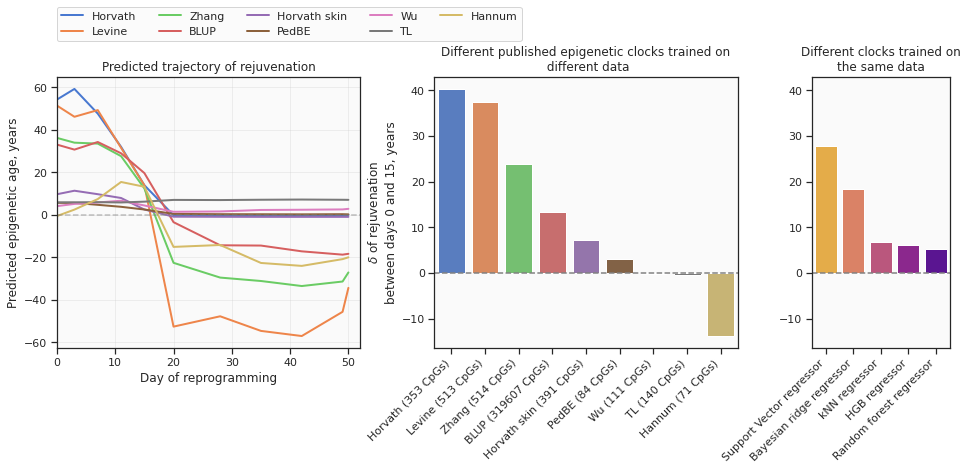

In [4]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.colors as color

fig, axes = plt.subplots(1, 3, figsize=(16,5), gridspec_kw={'width_ratios':[11,11,5]})
color_iters = sns.color_palette('muted') 

#ax1
delta_rep = groupr.loc[repday0] - groupr.loc[repday1]
delta_rep = delta_rep.sort_values(ascending=False).to_frame().reset_index()
delta_rep.columns = ['clock', 'delta']
#delta_rep['clock'] = delta_rep['clock'].map(METHYLCLOCK_NAMES_MAPPER)

sns.barplot(data=delta_rep, y='delta', x='clock', orient='v', ax=axes[1], palette=color_iters)
axes[1].set_xlabel('')
axes[1].set_ylabel(f'$\delta$ of rejuvenation\nbetween days {repday0} and {repday1}, years')
axes[1].set_title('Different published epigenetic clocks trained on\n different data')
axes[1].axhline(0, color='grey', ls='--')
axes[1].annotate('ElasticNet trained \non different datasets', xy=(10, 92.5), ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


#ax0
for clri, c in zip(color_iters, delta_rep['clock']):
    ctext = c.split('(')[0][:-1]
    axes[0].plot(groupr.index, groupr[c], label=ctext, lw=2, color=clri)
axes[0].legend(loc=[0.0, 1.13], ncol=5)
axes[0].grid(alpha=0.3)
axes[0].axhline(0, ls='--', alpha=0.5, color='grey')
axes[0].set_xlim([0, 52])
axes[0].set_xlabel('Day of reprogramming')
axes[0].set_ylabel('Predicted epigenetic age, years')
axes[0].set_title('Predicted trajectory of rejuvenation')


#ax2
delta_rep2 = groupr2.loc[0] - groupr2.loc[15]
delta_rep2 = delta_rep2.sort_values(ascending=False).to_frame().reset_index()
delta_rep2.columns = ['clock', 'delta']

sns.barplot(data=delta_rep2, y='delta', x='clock', orient='v', ax=axes[2], palette='plasma_r')
axes[2].annotate('Trained on \nHannum\'s blood \ndataset 71 CpGs', xy=(0, 85))
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_title('Different clocks trained on\nthe same data')
axes[2].axhline(0, color='grey', ls='--')
axes[2].set_ylim(axes[1].get_ylim())
# axes[2].set_yticklabels([])

plt.subplots_adjust(wspace=0.3)
plt.savefig('figs/A2_main_rep1.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Check covariate shift

In [5]:
#choose subset of data for covariate shift detection, it is reasonable to use 
#the portion of data selected by another "trustable" model
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

389 common sites


14.4% of sites are not rejected by KS test


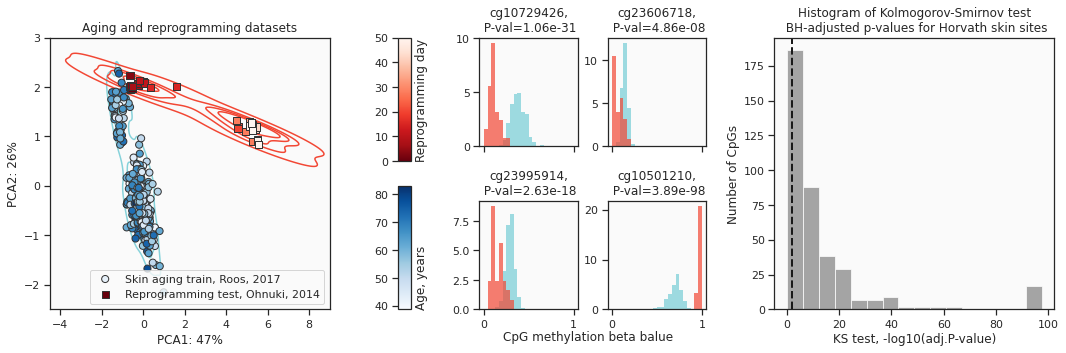

In [6]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Reds_r',
                        color_train = '#86d2da',
                        color_test = '#f24734',
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Reprogramming day',
                        legend_label_train = 'Skin aging train, Roos, 2017',
                        legend_label_test = 'Reprogramming test, Ohnuki, 2014',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Horvath skin sites',
                        pca_title = 'Aging and reprogramming datasets',
                        pca_legend_pos = 'lower right',
                        pca_xlim = [-4.5, 9],
                        pca_ylim = [-2.5, 3.]                   
                        )
plt.savefig('figs/A1_main_rep1.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [7]:
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.10, random_state=10)

389 common sites


Step 1 results:
R2 train = 0.921
MAE train = 2.095
R2 test = 0.829
MAE test = 2.796
------------------------------
Step 2 results:
R2 train = 0.759
MAE train = 3.33
R2 test = 0.646
MAE test = 4.436
------------------------------


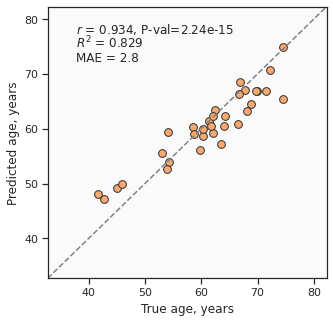

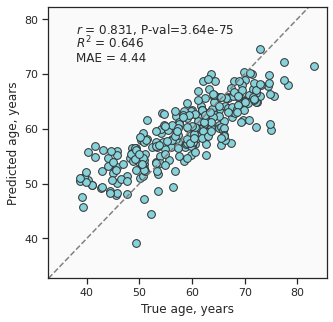

In [8]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_test, y_test_predict_step1, eq_bounds=(35, 80), color='#f9a86f', markersize=60)
plt.savefig('figs/A3_aging_skin_train_test_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_skin_train_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 0.921
MAE train = 2.095
------------------------------
Step 2 results:
R2 test = -32.794
MAE test = 52.718
------------------------------


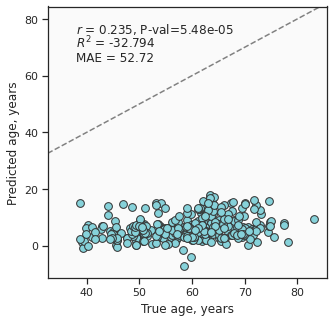

In [9]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_skin_train_rep1_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

389 common sites
R2 train = 0.9725021821426049
R2 test = 0.8661882431814276
MAE train = 1.2045615654522586
MAE test = 2.7247543561644134
------------------------------
Resulting kernel: 98**2 * RBF(length_scale=11.9) + WhiteKernel(noise_level=5.51)


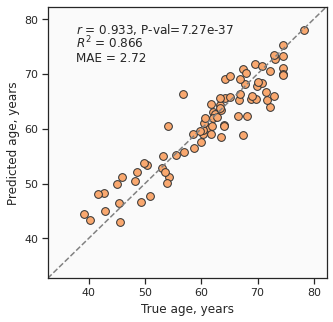

In [10]:
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80), color='#f9a86f', markersize=60)
plt.savefig('figs/A4_sup_GP_skin_test_performance.pdf', format='pdf', bbox_inches='tight')

Avg uncertainty std: 23.027349798952
P-value of rejuvenation effect between 0 and 15 days is 0.27946007200562706
P-value of rejuvenation effect between 0 and 20 days is 0.0002847129331624565


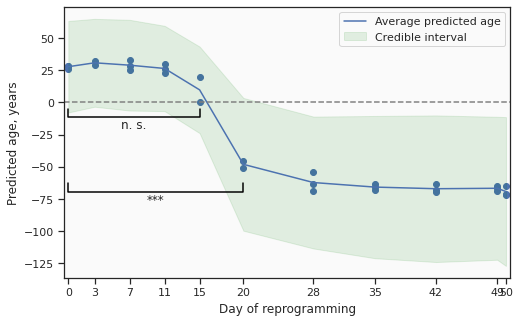

In [11]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr.values, y_test_predict_r, y_test_std_r, 
                      days=[(0, 15), (0, 20)], #days of reprogramming for pairwise comparison
                      nstd=2, dh=0.07, barh=0.03)
plt.savefig('figs/A4_rep1_trajectory.pdf', format='pdf', bbox_inches='tight')

# GSE90124 -> GSE165179 (Aging Skin -> Transient reprogramming)

In [14]:
#Aging, Roos, 2017
dfa, meta = pd.read_pickle('datasets/GSE90124.pkl').values()
dfa = dfa.loc[meta.index]
print('Age, N sites', len(dfa.columns))

# #reprogramming data, Gill, Illumina EPIC, source=(https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE165180)
dfr, metr = pd.read_pickle('datasets/GSE165179.pkl').values()
dfr = dfr.loc[metr.index]
print('Rep, N sites', len(dfr.columns))

#methylclock output
methclock = pd.read_csv('subdata/GSE165179_methylclock_results.csv', index_col=1).drop('Unnamed: 0', axis=1)
methclock.index = metr.index
methclock['age'] = metr['DayReprog']

#Additional filtering. Use only transiently reprogrammed fibroblasts for comparison with intract ones
filt = ['Fibroblast', 'Transient reprogramming intermediate', 'iPSC']
cond = metr['Condition'].isin(filt)
metr = metr[cond]
dfr = dfr[cond]
methclock = methclock[cond].dropna(axis=1)
print(metr['Condition'].unique())

#Grouping predicted ages by same days
columns_include = ['Horvath', 'Levine', 'EN', 'skinHorvath', 'PedBE', 'Wu', 'TL', 'BLUP', 'Hannum', 'age']
methclock = methclock[columns_include]
groupr = methclock.groupby('age').mean()
groupr.columns = groupr.columns.map(METHYLCLOCK_NAMES_MAPPER)

#Days for pairwise comparison
repday0 = 0
repday1 = 17

Age, N sites 450531
Rep, N sites 865859
['Fibroblast' 'Transient reprogramming intermediate' 'iPSC']


## Methylclock models predict different rejuvenation dynamics

In [15]:
# different models same data

model_mapper = {'KNeighborsRegressor': 'kNN regressor',
                'HistGradientBoostingRegressor': 'HGB regressor',
                'SVR':'Support Vector regressor',
                'BayesianRidge': 'Bayesian ridge regressor',
                'RandomForestRegressor': 'Random forest regressor'
                }

#choose data subset
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

#import models
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

params = {
            KNeighborsRegressor: {"metric":['euclidean', 'l1', 'cosine'], 
                                  "n_neighbors":np.arange(2, 11),
                                  "weights":['uniform']},
            RandomForestRegressor: {"n_estimators":[200], 
                                    "max_depth":[3, 6, 10],
                                    'min_samples_split': [2, 5, 10],
                                    "n_jobs":[-1],},
            SVR: {"kernel":["linear"], "C":np.logspace(-1, 1, 10)},
            BayesianRidge: {},
            HistGradientBoostingRegressor: {"verbose":[0]},
          }

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=15)

perf_metrics = pd.DataFrame()
groupr2 = pd.DataFrame(index=yr)
for m, p in params.items():
    model = GridSearchCV(m(), p, scoring='neg_mean_absolute_error', refit=True, cv=cv_splitter)
    model.fit(X_train, y_train)
    print(model.best_estimator_)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    r_tr, p_tr = pearsonr(y_train, y_train_predict)
    r_te, p_te = pearsonr(y_test, y_test_predict)
    print(f'r train = {r_tr}')
    print(f'r test = {r_te}')
    print(f'r pval train = {p_tr}')
    print(f'r pval test = {p_te}')
    print(f'R2 train = {r2_score(y_train, y_train_predict)}')
    print(f'R2 test = {r2_score(y_test, y_test_predict)}')
    print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
    print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
    print('-'*30)

    y_rep_predict = model.predict(Xr_clock)
    groupr2[model_mapper[m.__name__]] = y_rep_predict

groupr2 = groupr2.groupby(groupr2.index).mean()

KNeighborsRegressor(metric='cosine', n_neighbors=4)
r train = 0.8439678217761898
r test = 0.6538186206104057
r pval train = 1.3547320209443015e-66
r pval test = 3.6487964606774405e-11
R2 train = 0.6987990725749825
R2 test = 0.4017683232033965
MAE train = 3.915124481327801
MAE test = 6.036543209876545
------------------------------
RandomForestRegressor(max_depth=6, min_samples_split=5, n_estimators=200,
                      n_jobs=-1)
r train = 0.9728473920577008
r test = 0.8315399501813934
r pval train = 6.734301636340874e-154
r pval test = 7.200853743787294e-22
R2 train = 0.9162011816465011
R2 test = 0.6274193661338544
MAE train = 2.0548751450272467
MAE test = 4.713777152711034
------------------------------
SVR(C=10.0, kernel='linear')
r train = 0.9633091162669789
r test = 0.9330522519938015
r pval train = 1.6040969146890245e-138
r pval test = 8.021315724639266e-37
R2 train = 0.9212330641016584
R2 test = 0.853712480244865
MAE train = 1.6032553104658593
MAE test = 2.923329815841121


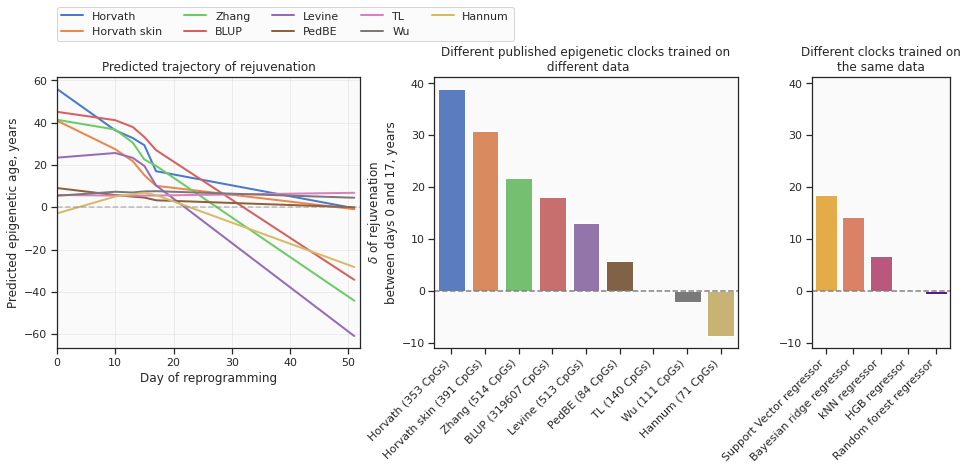

In [16]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.colors as color

fig, axes = plt.subplots(1, 3, figsize=(16,5), gridspec_kw={'width_ratios':[11,11,5]})
color_iters = sns.color_palette('muted') 

#ax1
delta_rep = groupr.loc[repday0] - groupr.loc[repday1]
delta_rep = delta_rep.sort_values(ascending=False).to_frame().reset_index()
delta_rep.columns = ['clock', 'delta']
#delta_rep['clock'] = delta_rep['clock'].map(METHYLCLOCK_NAMES_MAPPER)

sns.barplot(data=delta_rep, y='delta', x='clock', orient='v', ax=axes[1], palette=color_iters)
axes[1].set_xlabel('')
axes[1].set_ylabel(f'$\delta$ of rejuvenation\nbetween days {repday0} and {repday1}, years')
axes[1].set_title('Different published epigenetic clocks trained on\n different data')
axes[1].axhline(0, color='grey', ls='--')
axes[1].annotate('ElasticNet trained \non different datasets', xy=(10, 92.5), ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


#ax0
for clri, c in zip(color_iters, delta_rep['clock']):
    ctext = c.split('(')[0][:-1]
    axes[0].plot(groupr.index, groupr[c], label=ctext, lw=2, color=clri)
axes[0].legend(loc=[0.0, 1.13], ncol=5)
axes[0].grid(alpha=0.3)
axes[0].axhline(0, ls='--', alpha=0.5, color='grey')
axes[0].set_xlim([0, 52])
axes[0].set_xlabel('Day of reprogramming')
axes[0].set_ylabel('Predicted epigenetic age, years')
axes[0].set_title('Predicted trajectory of rejuvenation')


#ax2
delta_rep2 = groupr2.loc[0] - groupr2.loc[15]
delta_rep2 = delta_rep2.sort_values(ascending=False).to_frame().reset_index()
delta_rep2.columns = ['clock', 'delta']

sns.barplot(data=delta_rep2, y='delta', x='clock', orient='v', ax=axes[2], palette='plasma_r')
axes[2].annotate('Trained on \nHannum\'s blood \ndataset 71 CpGs', xy=(0, 85))
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_title('Different clocks trained on\nthe same data')
axes[2].axhline(0, color='grey', ls='--')
axes[2].set_ylim(axes[1].get_ylim())
# axes[2].set_yticklabels([])

plt.subplots_adjust(wspace=0.3)
plt.savefig('figs/A2_sup_rep2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Check covariate shift

In [17]:
#choose subset of data for covariate shift detection, it is reasonable to use 
#the portion of data using for model training
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

389 common sites


31.36% of sites are not rejected by KS test


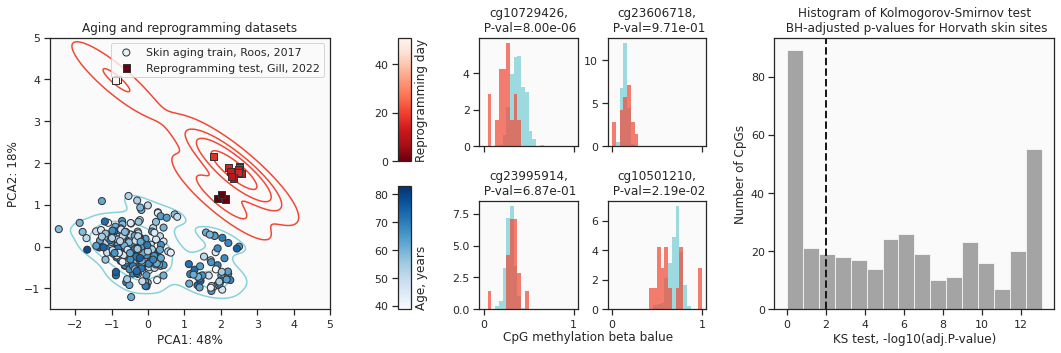

In [18]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Reds_r',
                        color_train = '#86d2da',
                        color_test = '#f24734',
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Reprogramming day',
                        legend_label_train = 'Skin aging train, Roos, 2017',
                        legend_label_test = 'Reprogramming test, Gill, 2022',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Horvath skin sites',
                        pca_title = 'Aging and reprogramming datasets',
                        pca_legend_pos = 'upper right',
                        pca_xlim = [-2.7, 5.0],
                        pca_ylim = [-1.5, 5.0]                   
                        )

plt.savefig('figs/A1_sup_rep2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [19]:
# Aging -> Reprogramming in vitro
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.10, random_state=10)

389 common sites


Step 1 results:
R2 train = 0.921
MAE train = 2.095
R2 test = 0.829
MAE test = 2.796
------------------------------
Step 2 results:
R2 train = 0.759
MAE train = 3.33
R2 test = 0.646
MAE test = 4.436
------------------------------


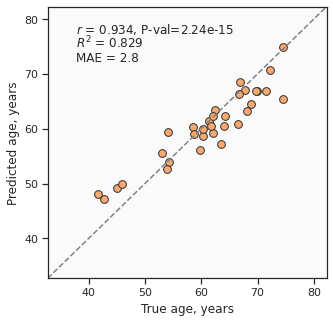

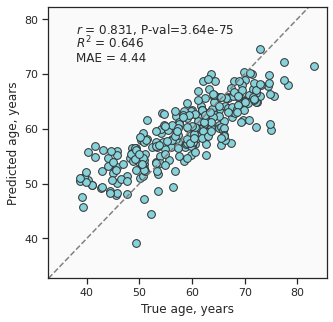

In [20]:
#case 1
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_test, y_test_predict_step1, eq_bounds=(35, 80), color='#f9a86f', markersize=60)
plt.savefig('figs/A3_aging_skin_train_test_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_skin_train_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 0.921
MAE train = 2.095
------------------------------
Step 2 results:
R2 test = -13.984
MAE test = 34.344
------------------------------


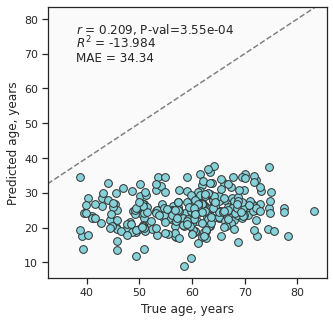

In [21]:
#case 2
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_skin_train_rep2_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

389 common sites
R2 train = 0.9725021028960291
R2 test = 0.8661883281722473
MAE train = 1.2045633224687309
MAE test = 2.724753544462613
------------------------------
Resulting kernel: 98**2 * RBF(length_scale=11.9) + WhiteKernel(noise_level=5.51)


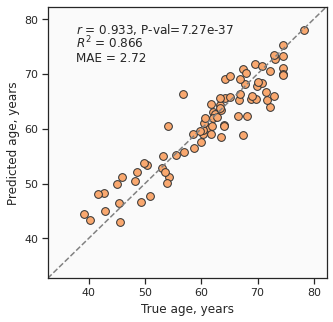

In [22]:
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['DayReprog']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80), color='#f9a86f', markersize=60)
plt.savefig('figs/A4_sup_GP_skin_test_performance.pdf', format='pdf', bbox_inches='tight')

Avg uncertainty std: 17.314459419502043
P-value of rejuvenation effect between 0 and 17 days is 0.013612033810199042
P-value of rejuvenation effect between 0 and 15 days is 0.24318095602684697


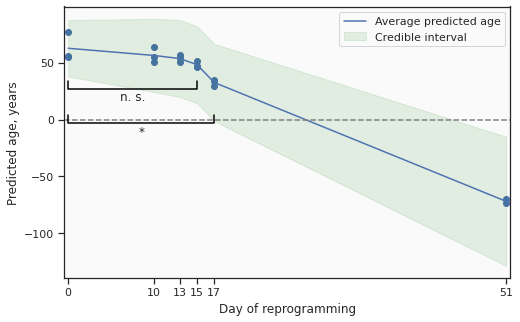

In [23]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr.values, y_test_predict_r, y_test_std_r, 
                      days=[(repday0, repday1), (0, 15)], 
                      nstd=2, dh=[0.12, 0.06], barh=0.03)
plt.savefig('figs/A4_rep2_trajectory.pdf', format='pdf', bbox_inches='tight')